# Joseph Korban's Notebook

## Goal: DL Model

#### Preliminary Steps

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os

import tensorflow as tf

In [2]:
# df = pd.read_csv('/content/Full_data.csv')
# df_droptime = df.drop(columns='Unnamed: 0')
# df_droptime


In [3]:
# df = pd.read_csv('/content/BTCUSDT_daily_Binance.csv')
# df_droptime = df.drop(columns='time')

# df_droptime.head()

In [4]:
df = pd.read_csv('/content/non_Scaled_full.csv')
df_droptime = df.drop(columns='Unnamed: 0')
df_droptime.head()

,open,high,low,close,volume BTC,volume USD,FAGI_score,scored_title,scored_text,average_score,twitter_followers,twitter_favourites,reddit_subscribers,reddit_active_users,reddit_comments_per_day,FAGI_sentiment_encoded
0,4261.48,4485.39,4200.74,4285.08,795.150377,3.454770e+06,50.0,0.0,0.0,0.0,1000.000000,2163.435644,1000.000000,1747.715439,699.824346,2.0
1,4285.08,4371.52,3938.77,4108.37,1199.888264,5.086958e+06,50.0,0.0,0.0,0.0,2209.747759,2163.435644,1419.855422,1747.715439,699.824346,2.0
2,4108.37,4184.69,3850.00,4139.98,381.309763,1.549484e+06,50.0,0.0,0.0,0.0,3419.495519,2163.435644,1839.710843,1747.715439,699.824346,2.0
3,4139.98,4211.08,4032.62,4086.29,467.083022,1.930364e+06,50.0,0.0,0.0,0.0,4629.243278,2163.435644,2259.566265,1747.715439,699.824346,2.0
4,4069.13,4119.62,3911.79,4016.00,691.743060,2.797232e+06,50.0,0.0,0.0,0.0,5838.991037,2163.435644,2679.421687,1747.715439,699.824346,2.0


#### Assignments:
- Targets  
- Number of targets
- Number of features


In [5]:
# Can change later

N_FEATURES = df_droptime.shape[1]  # All features other than time
N_TARGETS = 1                      # Prediciting only 1 target (close price)
TARGET = 'close'


## Preparing the dataset for DL Model

### Step 1. Creating many folds

#### Assignments:
- Fold Length   
- Fold Size
- Train Test Ratio


In [6]:
# Can change later

# Since we have data for about 6.3 years, we will asssume fold lengths of 2 years
# 1.34 years for training and 0.67 for testing

FOLD_LENGTH = 365 * 2     # Assume fold legnth of 2 years
FOLD_STRIDE = 91          # Assume stride every quarter
TRAIN_TEST_RATIO = 0.67   # Two-thirds split ratio


#### * Implement the Get Folds Function:
- Takes in df, fold length, fold stride
- Returns a list of folds (each fold being a dataframe)

In [7]:
# Goes through the dataframe and creates equal sized folds of FOLD_LENGTH
# starting at 0 and at each FOLD_STRIDE until it crosses len(df)

def get_folds(df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> list[pd.DataFrame]:

    folds = []
    for index in range(0, fold_length, fold_stride):
        if index + fold_length > len(df):
            break
        fold = df.iloc[index:index + fold_length,:]
        folds.append(fold)
    return folds


In [8]:
folds = (get_folds(df_droptime,FOLD_LENGTH,FOLD_STRIDE))
print(f'Number of folds created were {len(folds)}')
print(f'Each with a shape equal to {folds[0].shape}.')


Number of folds created were 9
Each with a shape equal to (730, 16).


### Step 2. Temporal Train Test Split for one fold

#### Focusing on one fold first

In [9]:
fold = folds[0]


#### Assignments:
- Input Length : Selected period selected for forecasting
- Output Length : Selected period we want to predict


In [10]:
# Can change later

INPUT_LENGTH = 4           # We can assume 3 days for a forecating period
OUTPUT_LENGTH = 1           # If we want predict only one timestep (day) ahead
TEMP_TRAIN_TEST_RATIO = 0.8 # How we want to split each fold (can be same as train test ratio)


#### * Implement the Temporal Train Test Split Function:
- Takes in a fold, temporal train test ratio, input length
- Returns a tuple of (fold_train, fold_test), each as a dataframe

In [11]:
# Splitting one fold into train and test chronologically,
# so we can later sample many (Xi,yi) pairs (input and output lengths)

def temporal_train_test_split(fold:pd.DataFrame,
                            temp_train_test_ratio: float,
                            input_length: int) -> tuple[pd.DataFrame]:
    # Train set
    last_train_index = round(temp_train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_index, :]

    #Test Set
    first_test_index = last_train_index - input_length
    fold_test = fold.iloc[first_test_index:, :]

    return (fold_train,fold_test)


In [12]:
(fold_train, fold_test) = temporal_train_test_split(fold, TEMP_TRAIN_TEST_RATIO, INPUT_LENGTH)


In [13]:
fold_train.shape, fold_test.shape


((584, 16), (150, 16))

### Step 3. Create (X, y) sequences

### Option 1. Random Sampling

#### Now that we split our fold into trian and test we have to create 2 functions
- One that will return a single sequence of (Xi, yi) (from fold train for training, and from fold test for evaluating)
- Another that will call the first function many times over creating 3-D arrays of multiple sequences (X, y)

#### * Implement the Get (Xi, yi) function (using the random method):
- Takes in a fold, input length ,output length
- Returns a single sequence of (Xi, yi) as a 2-D DataFrame

In [14]:
# Given a fold (could be train fold for testing or test fold for evaluating),
# it will return a sequence of (Xi,yi) based on input and output lengths,
# starting from a random point.

def get_Xi_yi(fold:pd.DataFrame,
              input_length:int,
              output_length:int):

    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length]
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length][[TARGET]]

    return (X_i, y_i)


In [15]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)


In [16]:
X_train_i.shape, y_train_i.shape


((4, 16), (1, 1))

In [17]:
X_test_i.shape, y_test_i.shape


((4, 16), (1, 1))

#### Assignments:
- Number of sequences train : How many sequences do we want to collect from X_train
- Number of sequences test : How many sequences do we want to collect from X_test


In [18]:
# Can change later

N_TRAIN = 500 # number_of_sequences_train
N_TEST =  250 # number_of_sequences_test


#### * Implement the Get (X,y) Function:
- Takes in fold, number of sequences, input length, output length
- Returns (X, y) as a 3-D array

In [19]:
# Uses the previous get_Xi_yi function and loops based on number of sequences,
# and returns your complete X_train, y_train as 3-D arrays of
#( Number of sequences, time steps, number of features(targets) )

def get_X_y(fold:pd.DataFrame,
            number_of_sequences:int,
            input_length:int,
            output_length:int):

    X, y = [], []

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(fold, input_length, output_length)
        X.append(Xi)
        y.append(yi)

    return np.array(X), np.array(y)


In [20]:
X_train, y_train = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
X_test, y_test = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)


In [21]:
X_train.shape, y_train.shape


((500, 4, 16), (500, 1, 1))

In [22]:
X_test.shape, y_test.shape


((250, 4, 16), (250, 1, 1))

### Option 2. Chronological Sampling

#### Assignments:
- Sequence Stride: How many days of stride to collect data



In [23]:
# Can change later

SEQUENCE_STRIDE = 4


In [24]:
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, sequence_stride: int):

    # slides through a `fold` Time Series (2D array) to create sequences of equal
    # input_length for X, output_length for y,
    # using a temporal gap `sequence_stride` between each sequence
    # and returns a list of sequences, each as a 2D-array time series

    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        if (i + input_length + output_length) > len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][[TARGET]]
        X.append(X_i)
        y.append(y_i)

    return np.array(X), np.array(y)

In [25]:
# X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
# X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

# print(X_train.shape)
# print(y_train.shape)


In [26]:
# print(X_test.shape)
# print(y_test.shape)

## Modeling

In [27]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import regularizers


### Step 1. Building a Baseline (dummy) model for comparisons

#### * Initialize the Baseline Model function based on last seen value

In [67]:
def init_baseline():

    model = models.Sequential()
    model.add(layers.Lambda(lambda x: x[:,-1,3,None]))

    adam = optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mse', optimizer=adam, metrics=["mse",'mae'])

    return model


In [68]:
base_model = init_baseline()
base_model.fit(X_train,y_train)


16/16 [==============================] - 0s 3ms/step - loss: 214434.6562 - mse: 214434.6562 - mae: 241.8727


In [69]:
baseline_score = base_model.evaluate(X_test,y_test)


8/8 [==============================] - 0s 3ms/step - loss: 168257.9062 - mse: 168257.9062 - mae: 279.7512


### Step 2. Building an LSTM Model

#### * Initialize the LSTM Model function

In [79]:
def init_model(X_train, y_train):

    adam = optimizers.Adam(learning_rate=0.01)
    #reg_l2 = regularizers.L2(0.5)

    output_length = y_train.shape[1]*y_train.shape[2]

    normalizer = Normalization()
    normalizer.adapt(X_train)

    model = models.Sequential()

    model.add(normalizer)
    model.add(layers.LSTM(124,
                          activation='tanh',
                          return_sequences = True,
                          ))
    model.add(layers.LSTM(64,
                          activation='tanh',
                          return_sequences = True,
                          ))
    model.add(layers.LSTM(32,
                          activation='tanh',
                          return_sequences = True
                          ))
    model.add(layers.LSTM(16,
                          activation='tanh',
                          return_sequences = False
                          ))

    model.add(layers.Dense(10, activation='relu'
                           ))

    model.add(layers.Dense(output_length, activation='linear'))

    model.compile(loss='mse', optimizer=adam, metrics=["mse",'mae'])

    return model


#### * Fit (Train) the LSTM Model function

In [80]:
def fit_model(model: tf.keras.Model, verbose=1) -> tuple[tf.keras.Model, dict]:

    es = EarlyStopping(monitor = "val_loss",
                      patience = 20,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 16,
                        epochs = 100,
                        callbacks = [es],
                        verbose = verbose)

    return model, history


#### * Define the plot history function

In [81]:
def plot_history(history):

    fig, ax = plt.subplots(1,2, figsize=(20,7))
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    return ax


In [82]:
model = init_model(X_train, y_train)

model, history = fit_model(model)


Epoch 1/100
22/22 [==============================] - 9s 86ms/step - loss: 57114332.0000 - mse: 57114332.0000 - mae: 6997.5806 - val_loss: 62138948.0000 - val_mse: 62138948.0000 - val_mae: 7246.3906
Epoch 2/100
22/22 [==============================] - 0s 16ms/step - loss: 56864164.0000 - mse: 56864164.0000 - mae: 6979.6270 - val_loss: 61770608.0000 - val_mse: 61770608.0000 - val_mae: 7220.9302
Epoch 3/100
22/22 [==============================] - 0s 16ms/step - loss: 56371652.0000 - mse: 56371652.0000 - mae: 6944.1392 - val_loss: 61088920.0000 - val_mse: 61088920.0000 - val_mae: 7173.5732
Epoch 4/100
22/22 [==============================] - 0s 16ms/step - loss: 55554676.0000 - mse: 55554676.0000 - mae: 6884.9136 - val_loss: 60053936.0000 - val_mse: 60053936.0000 - val_mae: 7101.0684
Epoch 5/100
22/22 [==============================] - 0s 16ms/step - loss: 54394428.0000 - mse: 54394428.0000 - mae: 6799.9658 - val_loss: 58663444.0000 - val_mse: 58663444.0000 - val_mae: 7002.4766
Epoch 6/10

array([<Axes: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

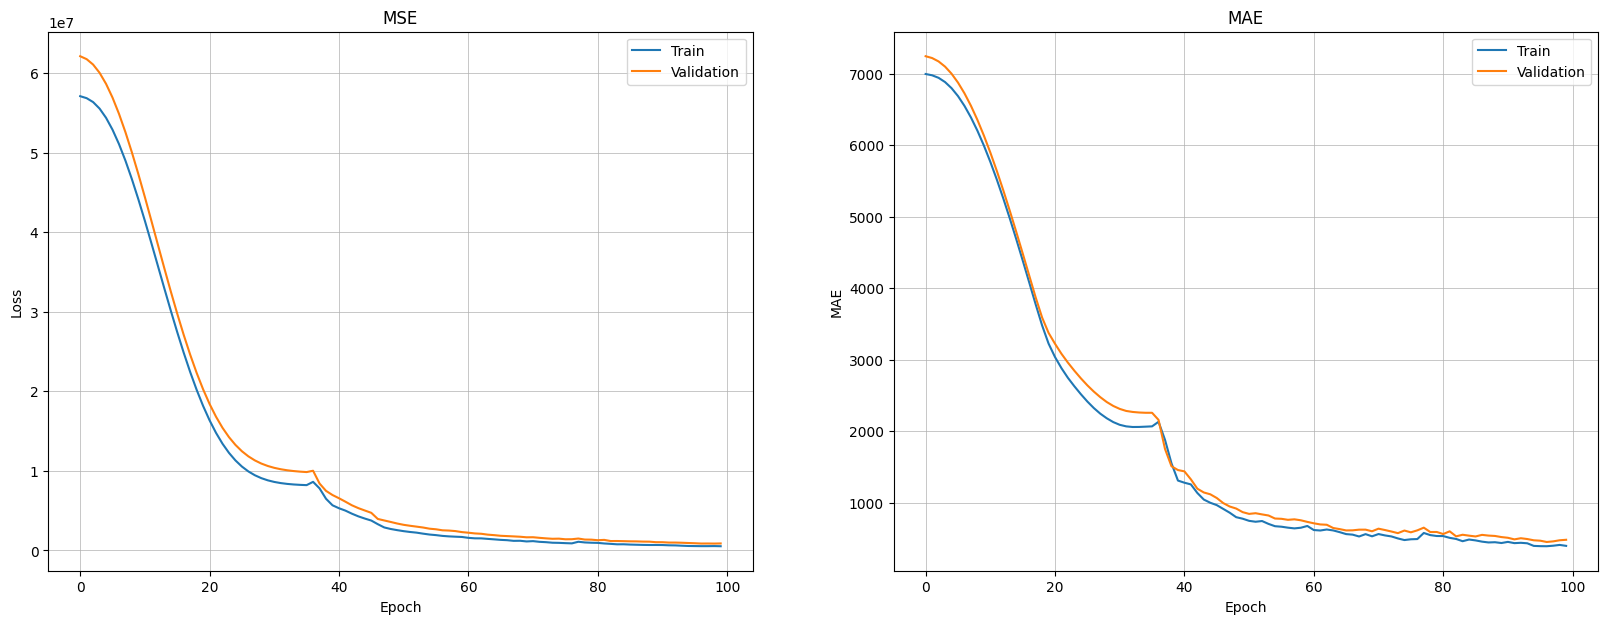

In [83]:
plot_history(history)


In [84]:
res = model.evaluate(X_test,y_test)


8/8 [==============================] - 0s 5ms/step - loss: 4260698.5000 - mse: 4260698.5000 - mae: 1846.2963


In [85]:
print(f'Improvement over baseline model is {((baseline_score[2] - res[2])/baseline_score[2])*100} %')

Improvement over baseline model is -559.9779118060567 %


#### All this was for one fold, now we need to Cross validate on all folds

### Step 3. Cross Validation

#### * Funtion to Cross Validate for Baseline and LSTM Models in for loop

In [77]:
def cross_validate_baseline_and_lstm():
    '''
    This function cross-validates
    - the "last seen value" baseline model
    - the RNN model
    '''

    list_of_mae_baseline_model = []
    list_of_mae_recurrent_model = []

    # 0 - Creating folds
    # =========================================
    folds = get_folds(df_droptime, FOLD_LENGTH, FOLD_STRIDE)

    for fold_id, fold in enumerate(folds):

        # 1 - Train/Test split the current fold

        (fold_train, fold_test) = temporal_train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

        X_train, y_train = get_X_y_strides(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
        X_test, y_test = get_X_y_strides(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

        # 2 - Modelling

        ##### Baseline Model
        baseline_model = init_baseline()
        mae_baseline = baseline_model.evaluate(X_test, y_test, verbose=0)[2]
        list_of_mae_baseline_model.append(mae_baseline)
        print("-"*50)
        print(f"MAE baseline fold n°{fold_id} = {round(mae_baseline, 2)}")

        ##### LSTM Model
        model = init_model(X_train, y_train)
        history = fit_model(model)
        # es = EarlyStopping(monitor = "val_mae",
        #                    mode = "min",
        #                    patience = 2,
        #                    restore_best_weights = True)
        # history = model.fit(X_train, y_train,
        #                     validation_split = 0.3,
        #                     shuffle = False,
        #                     batch_size = 32,
        #                     epochs = 50,
        #                     callbacks = [es],
        #                     verbose = 0)
        res = model.evaluate(X_test, y_test, verbose=0)
        mae_lstm = res[2]
        list_of_mae_recurrent_model.append(mae_lstm)
        print(f"MAE LSTM fold n°{fold_id} = {round(mae_lstm, 2)}")

        ##### Comparison LSTM vs Baseline for the current fold
        print(f"🏋🏽‍♂️ improvement over baseline: {round((1 - (mae_lstm/mae_baseline))*100,2)} % \n")

    return list_of_mae_baseline_model, list_of_mae_recurrent_model


In [78]:
mae_baselines, mae_lstms = cross_validate_baseline_and_lstm()


ValueError: ignored

In [ ]:
print(f"average percentage improvement over baseline = {round(np.mean(1 - (np.array(mae_lstms)/np.array(mae_baselines))),2)*100}%")
